In [5]:
!git clone https://github.com/comptech-winter-school/covid19-prediction

Cloning into 'covid19-prediction'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 7), reused 7 (delta 4), pack-reused 0
Receiving objects: 100% (20/20), 94.99 MiB | 11.59 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (9/9), done.


<h1>Библиотеки и функции</h1>

In [1]:
from pathlib import Path
import pandas as pd 
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt
import sklearn

%matplotlib inline

In [3]:
def get_plot(country_first, country_second):
    """Строит график для страны country_first и страны country_second"""
    s = [country_first]
    if country_second:
        s.append(country_second)
        
    for country in s:
        a = gr[gr["Country_Region"] == country]
        signal = (a["Confirmed"] - a["Confirmed"].shift(1)).to_numpy()
        signal = savgol_filter(signal, 51, 2)
        
        # model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
        # algo = rpt.Window(width=50, model=model).fit(signal)
        # result = algo.predict(n_bkps=10)
        
        plt.title(country)
        plt.plot(a.index, signal)
        plt.gcf().autofmt_xdate(rotation=90, ha='center')
        plt.show()
        

cache = {}
    
def get_new_cases(d, c):
    """Взятие новых кейсов из датафрейма d для страны c и их сглаживание фильтром"""
    c1 = cache.get(c)
    if not c1 is None:
        return c1
    
    new_v = d[d["Country_Region"] == c]["Confirmed"]
    c1 = (new_v - new_v.shift(1)).dropna()
    try:
        f = savgol_filter(c1.to_numpy(), 51, 2)
        c1 = pd.Series(f, index=new_v.index[:-1])
        cache[c] = c1
        return c1
    except ValueError as e:
        return pd.Series()

<h1>Взятие данных</h1>

In [6]:
path = "covid19-prediction"
all_files = Path(path).glob("data*.csv") 

df = pd.concat(map(pd.read_csv, all_files))

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/concat.py:294: DtypeWarning: Columns (17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  op = _Concatenator(


In [7]:
df.head()

,Unnamed: 0,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,...,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio,Province/State,Country/Region,Last Update,Latitude,Longitude
0,485,22027.0,Claiborne,Louisiana,US,2020-05-24 02:32:43,32.823085,-92.995269,58.0,10.0,...,"Claiborne, Louisiana, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,486,28021.0,Claiborne,Mississippi,US,2020-05-24 02:32:43,31.970617,-90.907022,57.0,1.0,...,"Claiborne, Mississippi, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,487,47025.0,Claiborne,Tennessee,US,2020-05-24 02:32:43,36.483191,-83.659473,8.0,0.0,...,"Claiborne, Tennessee, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,488,53009.0,Clallam,Washington,US,2020-05-24 02:32:43,48.047546,-123.922632,25.0,0.0,...,"Clallam, Washington, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,489,26035.0,Clare,Michigan,US,2020-05-24 02:32:43,43.987942,-84.848199,17.0,2.0,...,"Clare, Michigan, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h1>Итоги разведки данных</h1>
<ol>
<li>Содержатся некоторые лишние столбцы, которые дублируют друг друга.</li>
<li>Содержатся регионы, от которых нам для простоты нужно избавиться.</li>
<li>Поле Confirmed - это поле, к которому каждый день прибавляется некоторое число заболевших. То есть если нужно получить количество новых случаев в день - делаем шифт, вычетаем.</li>
<li>Для простоты будем анализировать только большие страны (где Confirmed > 100000)</li>
</ol>

<h1>Предобработка</h1>

In [14]:
df["Last_Update"] = pd.to_datetime(df["Last_Update"]).dt.date
df = df[["Country_Region", "Last_Update", "Confirmed"]]
df.dropna(inplace=True)

# Избавляемся от региональности - смотрим в масштабе страны
gr = df.groupby(["Country_Region", "Last_Update"]).sum().reset_index().copy()
gr.index = gr["Last_Update"].copy()
del gr["Last_Update"]
gr.sort_index(inplace=True)

In [15]:
del df

In [16]:
countries = []

for country in np.unique(gr["Country_Region"].to_numpy()):
    if gr[gr["Country_Region"] == country]["Confirmed"].iloc[-1] > 100000:
        countries.append(country)

In [17]:
countries[:10]

['Afghanistan',
 'Albania',
 'Algeria',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh']

In [18]:
len(countries)

119

In [19]:
gr = gr[gr["Country_Region"].isin(countries)]

<h1>Нахождение "лага"</h1>
Ищем через смещение + максимальную корреляцию двух временных рядов.

In [11]:
import itertools

result = dict()
for coutries_pair in itertools.combinations(countries, 2):
    c_one, c_two = coutries_pair
    if c_one == "Russia" or c_two == "Russia":
        c1 = get_new_cases(gr, c_one)
        c2 = get_new_cases(gr, c_two)
        values = []
        for i in range(-100, 100, 1):
            values.append((c1.shift(i).corr(c2), i))
            
        result[coutries_pair] = max(values, key=lambda x: x[0])

In [12]:
result_25 = sorted(
    filter(
        lambda x: x[1][0] == x[1][0] and ((x[1][1] < 0 and x[0][0] == "Russia") or (x[1][1] > 0 and x[0][1] == "Russia")), 
        result.items()), 
    key=lambda x: x[1], 
    reverse=True
)

def filter_results(result, country):
    r = sorted(
        filter(
            lambda x: x[1][0] == x[1][0] and ((x[1][1] < 0 and x[0][0] == country) or (x[1][1] > 0 and x[0][1] == country)), 
            result.items()), 
        key=lambda x: x[1], 
        reverse=True
    ) 
    res = []
    for i in r:
        first_country = i[0][0] == country
        appended = (
            i[0][1] if first_country else i[0][0],
            i[1][1] if first_country else -i[1][1],
            i[1][0]
        )
        res.append(appended)
    
    return res

In [13]:
for i in result_25[:10]:
    print(f"{i[0][0]} похожа на {i[0][1]} с переносом {i[1][1]} дней. Степень уверенности: {i[1][0]}")
    # страна1 страна2 лаг степень уверенности

Iraq похожа на Russia с переносом 99 дней. Степень уверенности: 0.908748261889193
Russia похожа на Uzbekistan с переносом -93 дней. Степень уверенности: 0.8710160218504092
Costa Rica похожа на Russia с переносом 68 дней. Степень уверенности: 0.8523622645894275
Georgia похожа на Russia с переносом 4 дней. Степень уверенности: 0.844125445335424
Russia похожа на Venezuela с переносом -100 дней. Степень уверенности: 0.7784374885285897
Guatemala похожа на Russia с переносом 84 дней. Степень уверенности: 0.7783459619359971
Lithuania похожа на Russia с переносом 7 дней. Степень уверенности: 0.7749932966065529
Libya похожа на Russia с переносом 92 дней. Степень уверенности: 0.762064071627624
Philippines похожа на Russia с переносом 74 дней. Степень уверенности: 0.7562405325644483
Kazakhstan похожа на Russia с переносом 95 дней. Степень уверенности: 0.7416325812836705


In [14]:
filter_results(result, "Russia")

[('Iraq', -99, 0.908748261889193),
 ('Uzbekistan', -93, 0.8710160218504092),
 ('Costa Rica', -68, 0.8523622645894275),
 ('Georgia', -4, 0.844125445335424),
 ('Venezuela', -100, 0.7784374885285897),
 ('Guatemala', -84, 0.7783459619359971),
 ('Lithuania', -7, 0.7749932966065529),
 ('Libya', -92, 0.762064071627624),
 ('Philippines', -74, 0.7562405325644483),
 ('Kazakhstan', -95, 0.7416325812836705),
 ('Iran', -83, 0.7370515778807922),
 ('Thailand', -80, 0.7301096556588234),
 ('Honduras', -99, 0.7275809264980097),
 ('Malaysia', -75, 0.7262985301857369),
 ('Cuba', -83, 0.7242668789233618),
 ('Bangladesh', -99, 0.72172708336647),
 ('Botswana', -96, 0.7069316265974488),
 ('Mongolia', -56, 0.7062839449027435),
 ('Latvia', -8, 0.6924324927587389),
 ('Sri Lanka', -70, 0.6819777123053963),
 ('Romania', -23, 0.6701013090758025),
 ('Burma', -91, 0.6603178969587536),
 ('Australia', -34, 0.6589997101514076),
 ('Rwanda', -100, 0.6580545570698594),
 ('Morocco', -80, 0.6558763716872278),
 ('Ukraine', -6

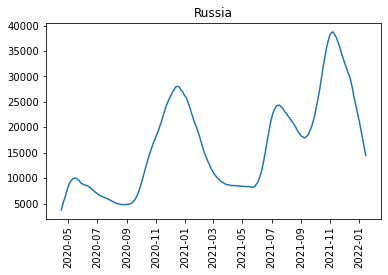

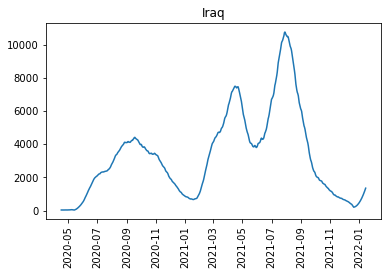

In [15]:
get_plot("Russia", "Iraq")

In [16]:
# import itertools

# delim = ';'
# result = dict()
# with open("graph.csv", "w") as f:
#     f.write(f"Country1{delim}Country2{delim}Lag{delim}Degree_of_certainty\n")
#     for coutries_pair in itertools.combinations(countries, 2):
#         c_one, c_two = coutries_pair
#         c1 = get_new_cases(gr, c_one)
#         c2 = get_new_cases(gr, c_two)
#         values = []
#         for i in range(-100, 100, 1):
#             values.append((c1.shift(i).corr(c2), i))

        
#         r = max(values, key=lambda x: x[0])
#         f.write(f"{c_one}{delim}{c_two}{delim}{r[1]}{delim}{r[0]}\n")

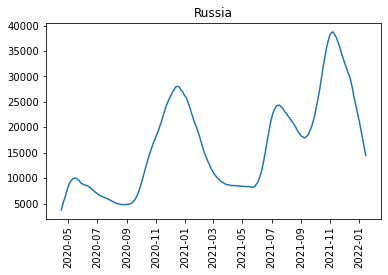

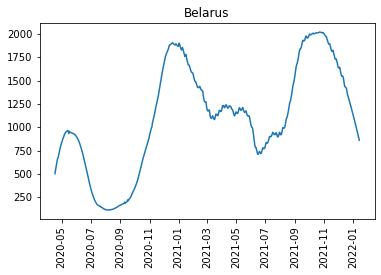

In [17]:
get_plot("Russia", "Belarus")

<h1>Предикт (модель)</h1>
<ol>
    <li>Для предикта используем последнюю неделю по заражению в данной конкретной стране</li>
    <li>Так же используем максимально похожие страны (пусть будет 25 стран) для взятия "степени крутости" на конкретный день</li>
    <li>Возьмём численную производную ещё и по той неделе, которую анализируем.</li>
</ol>

In [18]:
# (5 производных на момент ) (7 предыдущих дней новые кейсы) -> следующий день
def get_derivatives(df, graph_data, top_n=5):
    """Вернём производные топ 5ти похожих стран, которые идут до текущей страны"""
    derivatives = []
    for i, (country, day_ago, conf) in enumerate(filter(lambda x: x[1] < 0, graph_data)):
        if i + 1 == top_n:
            break
        
        country_data = df[df["Country_Region"] == country].shift(day_ago)["New_Cases"].iloc[:2].to_numpy()
        derivative = country_data[1] - country_data[0]  # численная производная, единица времени = день
        # Если нан - пусть производная будет единицей
        if not derivative:
            derivative = 1
        
        derivatives.append(derivative)
        
    return derivatives

<h1>Предикт - бейзлайн</h1>

In [19]:
def get_predict(df, predict_country, graph_data) -> int:
    """Вернёт цифирь, которая предсказывает заболеваемость для конкретной страны"""
    def get_mean(d, c, shift=0, deriv=False):
        """Взятие среднего за 7 дней периода, на который похожа predict_country страна в данный момент"""
        d_country = d[d["Country_Region"] == c].copy()
        new_cases = (d_country["Confirmed"] - d_country["Confirmed"].shift(1)).dropna()
        all_cases = d_country["Confirmed"].iloc[-1]
        if shift != 0:
            seven_days_mean = new_cases.iloc[shift-7:shift].to_numpy().mean()
        else:
            seven_days_mean = new_cases.iloc[-7:].to_numpy().mean()

        if seven_days_mean != seven_days_mean:
            return 0, all_cases
        if deriv:
            # Возвращаем коэффициент, который показывает во сколько раз растёт заболеваемость
            return new_cases.iloc[-1] / new_cases.iloc[-2], seven_days_mean, all_cases
        else:
            return seven_days_mean, all_cases

    d, mean, all_cases = get_mean(df, predict_country, deriv=True)

    result = 0
    weights = 0
    for country, lag, weight in graph_data:
        current_mean, current_cases = get_mean(df, country, lag)
        # Масштабируем число заражённых под данную страну
        coef = all_cases / current_cases
        # Берём коэффициент, на которым будем домножать
        current_mean = current_mean * coef
        # Суммируем
        weights += weight
        result += current_mean * weight

    return int(result / weights * d)

In [20]:
get_predict(gr, "Russia", filter_results(result, "Russia"))

17662

In [21]:
filter_results(result, "Russia")[:5]

[('Iraq', -99, 0.908748261889193),
 ('Uzbekistan', -93, 0.8710160218504092),
 ('Costa Rica', -68, 0.8523622645894275),
 ('Georgia', -4, 0.844125445335424),
 ('Venezuela', -100, 0.7784374885285897)]

In [20]:
r = gr[gr["Country_Region"] == "Russia"].copy()
r["New_Cases"] = (r["Confirmed"] - r["Confirmed"].shift(1)).dropna()
r.to_csv("russia_data.csv")